In [118]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'Total_Any_Tobacco_7days'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=5000, latent_dim=100, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/{field}.pkl')

print('Done')

Done


In [119]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [120]:
# Load ADNI model

import pickle

# adni = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/weights0.pkl', 'rb'))
adni = {'coef': None, 'intercept': 0}
adni['coef'] = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/corrBalanced.pkl', 'rb'))


list(adni.keys())

['coef', 'intercept']

In [121]:
dct['demos'][4][:20]

array([ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.])

In [122]:
import numpy as np

vals = []
synth_mean = np.zeros(34716)

for i in range(20):
    synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    synth_mean += np.mean(synth, axis=0)/20
    
    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in synth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(synth))

print(np.mean(vals))
print(np.std(vals))

-24.15704674202775
0.4166834140280378


In [123]:
# Height and AD https://pmc.ncbi.nlm.nih.gov/articles/PMC6037293/
# Observational studies have linked increased adult height with better cognitive performance and reduced 
# risk of Alzheimer’s disease (AD). It is unclear whether the associations are due to shared biological 
# processes that influence height and AD or due to confounding by early life exposures or environmental factors.

vals = []
nsynth_mean = np.zeros(34716)

for i in range(20):
    ndemo = []
    for d in dct['demos']:
        dd = d+0
        ndemo.append(dd)

    # ndemo[1] = 0*np.ones(len(ndemo[1]))
    ndemo[4] -= 15
    # ndemo[4] = 0*np.ones(len(ndemo[4]))
    # ndemo[4] -= 15
    
    nsynth = vae.transform(len(dct['demos'][0]), ndemo, dct['types'])
    nsynth_mean += np.mean(nsynth, axis=0)/20
    
    sum_logits = 0
    
    for fc in nsynth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(nsynth))

print(np.mean(vals))
print(np.std(vals))

-29.8205397529788
0.36790337914807564


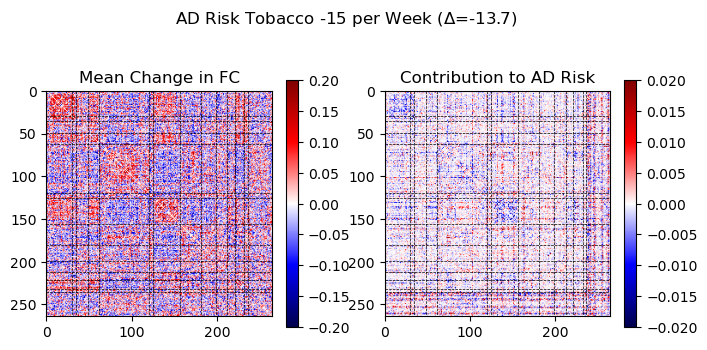

In [124]:
# Make two graphs: one mean change in FC, the other mean change in AD risk
# Use seismic or RdBu colormaps

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1,2,figsize=(8,4))

subject = 'Tobacco -15 per Week'
delta = '-13.7'
diff = nsynth_mean-synth_mean
diffw = w*diff
tit = subject.replace(' ', '_')

norm1 = TwoSlopeNorm(vmax=0.2, vmin=-0.2, vcenter=0)
norm2 = TwoSlopeNorm(vmax=0.02, vmin=-0.02, vcenter=0)

pos = ax[0].imshow(vec2mat(diff), norm=norm1, cmap='seismic')
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(vec2mat(diffw), norm=norm2, cmap='seismic')
fig.colorbar(pos, ax=ax[1], shrink=0.8)

for i in range(len(divis)-1):
    d = divis[i+1]
    ax[0].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[0].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')

ax[0].set_xlim([0,264])
ax[0].set_ylim([264,0])
ax[1].set_xlim([0,264])
ax[1].set_ylim([264,0])

ax[0].set_title('Mean Change in FC')
ax[1].set_title('Contribution to AD Risk')

fig.suptitle(f'AD Risk {subject} ($\\Delta$={delta})')
fig.show()
fig.savefig(f'/home/anton/Documents/Yale/HCP/Figures/FCChanges/{tit}.pdf')

In [125]:
# Individual ROIs

a,b = np.triu_indices(264,1)
top = np.argsort(np.abs(diffw))[::-1]
num = 8

print(tit, delta)
print('Individual ROIs')
for i in range(num):
    r1 = a[top[i]]
    r2 = b[top[i]]
    print(top[i], r1, r2, getlabel(r1), getlabel(r2), diffw[top[i]])

vals = []
sums = []
labs = []
W = vec2mat(diffw)

for i in range(len(divis)-1):
    for j in range(i,len(divis)-1):
        r1a = divis[i]
        r1b = divis[i+1]
        r2a = divis[j]
        r2b = divis[j+1]
        val = np.mean(W[r1a:r1b,r2a:r2b])
        vals.append(val)
        val = np.sum(W[r1a:r1b,r2a:r2b])
        sums.append(val)
        labs.append(f'{labels[i]}-{labels[j]}')

idcs = np.argsort(np.abs(vals))[::-1]

print('Networks Mean')
for i in range(num):
    print(vals[idcs[i]], labs[idcs[i]])

idcs = np.argsort(np.abs(sums))[::-1]

print('Networks Sum')
for i in range(num):
    print(sums[idcs[i]], labs[idcs[i]])

Tobacco_-15_per_Week -13.7
Individual ROIs
34437 239 261 UNK UNK -0.04216226593505586
34416 239 240 UNK UNK 0.03400158494781214
14479 62 127 DMN VIS 0.03310843943173384
33843 221 252 DRSL UNK -0.03278410806623556
7900 31 244 SMTM UNK 0.031223660625081414
26590 136 139 VIS VIS -0.030646864004895063
23687 114 261 DMN UNK 0.030067468690170383
23965 116 244 DMN UNK 0.0295899884621946
Networks Mean
-0.004026711757894162 SMTM-SMTM
-0.002537673923245318 CBL-CBL
-0.002126260996159413 VIS-VIS
-0.0015196671125492559 SMTM-MEM
-0.0014369671307587675 SMTH-SMTH
-0.0013265154874173674 VIS-DRSL
0.0010867237277128814 SMTM-UNK
-0.0010856458638833658 AUD-VIS
Networks Sum
-2.3872454179900995 DMN-DMN
-2.043336817309196 VIS-VIS
-1.2932704176828906 SMTH-SMTH
-0.731718185658131 SMTH-VIS
0.560529027373143 DMN-VIS
0.47555450734753146 SMTH-UNK
-0.4523417812093223 VIS-DRSL
-0.43751528314499644 AUD-VIS


In [177]:
np.sum(sums)

np.float64(0.32671763258463776)